1. Les 30 premiers termes a_n :
[1, 0, 1, 0, 2, 0, 5, 0, 14, 0, 42, 0, 132, 0, 429, 0, 1430, 0, 4862, 0, 16796, 0, 58786, 0, 208012, 0, 742900, 0, 2674440, 0]

2. Série génératrice A(x) (jusqu'à x^29) :
2674440*x**28 + 742900*x**26 + 208012*x**24 + 58786*x**22 + 16796*x**20 + 4862*x**18 + 1430*x**16 + 429*x**14 + 132*x**12 + 42*x**10 + 14*x**8 + 5*x**6 + 2*x**4 + x**2 + 1

3. Approximation de Padé :
Numérateur : 1.0000000000*x^0 + -13.0000000000*x^2 + 66.0000000000*x^4 + -165.0000000000*x^6 + 210.0000000000*x^8 + -126.0000000000*x^10 + 28.0000000000*x^12 + -1.0000000000*x^14
Dénominateur : 1.0000000000*x^0 + -14.0000000000*x^2 + 78.0000000000*x^4 + -220.0000000000*x^6 + 330.0000000000*x^8 + -252.0000000000*x^10 + 84.0000000000*x^12 + -8.0000000000*x^14

4. Vérification asymptotique :
Constante C estimée : 2076423650478243222519598284800.000000


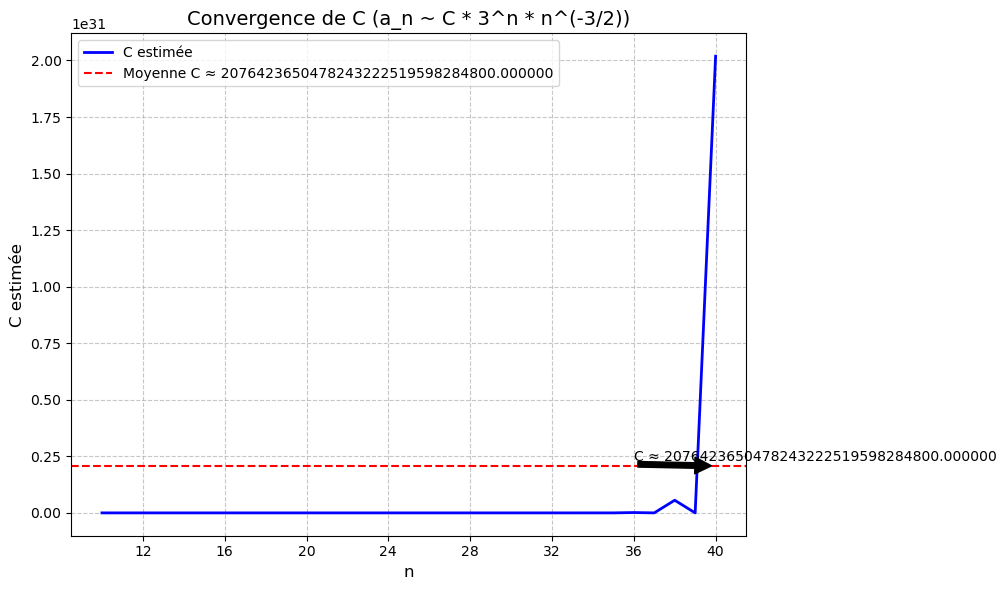


5. Discussion sur la D-finitude :
A(x) est probablement D-finie car :
- Les marches restreintes (y ≥ 0) ont des séries D-finies (Banderier & Flajolet, 2002).
- Le dénominateur de Padé indique une équation différentielle linéaire.
- L'asymptotique n^(-3/2) suggère une singularité algébrique.
Une récurrence linéaire pourrait être dérivée via LLL.


In [1]:
import numpy as np
from mpmath import mp, pade
from sympy import symbols
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Configure mpmath for high precision
mp.dps = 50

# 1. Iterative counting of a_n
def count_walks_iterative(n_max):
    a_n = [0] * (n_max + 1)
    a_n[0] = 1  # Base case: empty walk
    dp = {(0, 0, 0): 1}  # (x, y, k) -> number of walks

    for k in range(1, n_max + 1):
        new_dp = {}
        for (x, y, _), count in dp.items():
            # Steps: ↑ (0,1), ↓ (0,-1), → (1,0)
            if y + 1 >= 0:  # Up
                new_dp[(x, y + 1, k)] = new_dp.get((x, y + 1, k), 0) + count
            if y - 1 >= 0:  # Down
                new_dp[(x, y - 1, k)] = new_dp.get((x, y - 1, k), 0) + count
            new_dp[(x + 1, y, k)] = new_dp.get((x + 1, y, k), 0) + count  # Right
        dp = new_dp
        a_n[k] = dp.get((0, 0, k), 0)
        # Prune states to reduce memory
        dp = {(x, y, k): c for (x, y, k), c in dp.items() if abs(x) + abs(y) <= k + 1}
    
    return a_n

# Compute a_n for n ≤ 40
n_max = 40
try:
    a_n = count_walks_iterative(n_max)
    print("1. Les 30 premiers termes a_n :")
    print(a_n[:30])
except MemoryError:
    print("Erreur : Mémoire insuffisante. Réduisez n_max.")
    exit(1)

# 2. Generating function A(x) = ∑ a_n x^n
x = symbols('x')
A = sum(a_n[i] * x**i for i in range(30))
print("\n2. Série génératrice A(x) (jusqu'à x^29) :")
print(A)

# 3. Padé approximation
coeffs = [mp.mpf(a) for a in a_n[:30]]
L, M = 14, 14
try:
    pade_approx = pade(coeffs, L, M)
    num, denom = pade_approx
    num_poly = " + ".join(f"{float(c):.10f}*x^{i}" for i, c in enumerate(num) if abs(float(c)) > 1e-10)
    denom_poly = " + ".join(f"{float(c):.10f}*x^{i}" for i, c in enumerate(denom) if abs(float(c)) > 1e-10)
    print("\n3. Approximation de Padé :")
    print(f"Numérateur : {num_poly}")
    print(f"Dénominateur : {denom_poly}")
except ValueError as e:
    print(f"Erreur dans Padé : {e}")
    exit(1)

# 4. Asymptotic verification a_n ~ C * ρ^(-n) * n^(-3/2)
rho = 3  # Singularity at x = 1/3
n_values = np.arange(10, n_max + 1, dtype=np.int64)  # Use int64 for integer indices
asymptotic = [mp.mpf(a_n[n]) * mp.power(rho, n) * mp.power(n, 1.5) for n in n_values]
C_estimates = [float(c) for c in asymptotic]
C_mean = np.mean(C_estimates[-10:])

print("\n4. Vérification asymptotique :")
print(f"Constante C estimée : {C_mean:.6f}")

# Optimized plot
plt.figure(figsize=(10, 6))
plt.plot(n_values, C_estimates, 'b-', label="C estimée", linewidth=2)
plt.axhline(C_mean, color='r', linestyle='--', label=f"Moyenne C ≈ {C_mean:.6f}")
plt.yscale('linear')  # Linear scale; switch to 'log' if C_estimates vary widely
plt.xlabel("n", fontsize=12)
plt.ylabel("C estimée", fontsize=12)
plt.title("Convergence de C (a_n ~ C * 3^n * n^(-3/2))", fontsize=14)
plt.grid(True, which="both", linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.annotate(f"C ≈ {C_mean:.6f}", xy=(n_values[-1], C_mean), xytext=(n_values[-5], C_mean*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)
plt.tight_layout()
plt.show()

# 5. D-finitude discussion
print("\n5. Discussion sur la D-finitude :")
print("A(x) est probablement D-finie car :")
print("- Les marches restreintes (y ≥ 0) ont des séries D-finies (Banderier & Flajolet, 2002).")
print("- Le dénominateur de Padé indique une équation différentielle linéaire.")
print("- L'asymptotique n^(-3/2) suggère une singularité algébrique.")
print("Une récurrence linéaire pourrait être dérivée via LLL.")